# Fashion MNIST Tensorflow

Dataset and Description available on https://github.com/zalandoresearch/fashion-mnist

-- Download the repo using 

git clone git@github.com:zalandoresearch/fashion-mnist.git

-- Append the path of the repo from your local repo using sys.path.append

-- Read the files 

In [1]:
import sys
sys.path.append("C:/Users/parth/Desktop/Git/Projects/fashion-mnist")
from utils import mnist_reader

Read the train and test file

In [2]:
X_train, y_train = mnist_reader.load_mnist('C:/Users/parth/Desktop/Git/Projects/fashion-mnist/data/fashion', kind='train')
X_test, y_test = mnist_reader.load_mnist('C:/Users/parth/Desktop/Git/Projects/fashion-mnist/data/fashion', kind='t10k')

Checking the shapes of the files.

In [3]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(60000, 784)
(60000,)
(10000, 784)
(10000,)


Let's visualize few of the images

Labels:  [2, 9, 6, 0, 3, 4, 4, 5]


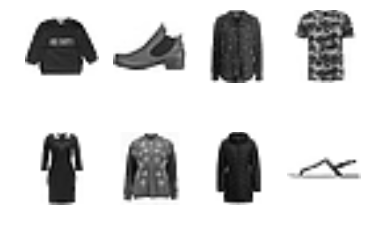

In [4]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
%matplotlib inline

print('Labels: ',[i for i in y_train[:8]])

for i in range(8):
    image = X_train[i].reshape(28,28)
    #print(image)
    plt.subplot(2,4,i+1)
    plt.axis('off')
    plt.imshow(image,cmap=cm.binary)

In [6]:
import numpy as np
# Standardize the data
X_train = np.multiply(X_train, 1.0 / 255.0)
X_test = np.multiply(X_test, 1.0 / 255.0)

In [7]:
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

The outout labels have 10 labels -> 0 to 9.
Let's use One Hot Encoder on the labels

In [8]:
def dense_to_one_hot(labels_dense, num_classes):
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot

y_train = dense_to_one_hot(y_train, 10)
y_train = y_train.astype(np.uint8)

print('y_train({0[0]},{0[1]})'.format(y_train.shape))
print ('y_train[{0}] => {1}'.format(0,y_train[0]))

y_train(60000,10)
y_train[0] => [0 0 1 0 0 0 0 0 0 0]


Create Train and Validation sets from the train data

In [39]:
'''
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(train_images, labels, test_size=0.2,random_state=42)

print(X_train.shape)
print(Y_train.shape)
print(X_val.shape)
print(Y_val.shape)
'''

(48000, 784)
(48000, 10)
(12000, 784)
(12000, 10)


Tensorflow Graph Initialization:
--------------------------------


Import Tensorflow

In [9]:
import tensorflow as tf

Weight and Bias Initialization

In [10]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape,stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1,shape=shape)
    return tf.Variable(initial)

Define Convolution and Max Pooling function

In [11]:
def conv2d(x,W):
    return tf.nn.conv2d(x,W,strides=[1,1,1,1],padding='SAME')
def max_pool_2x2(x):
    return tf.nn.max_pool(x,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')

Create placeholders for input and output

In [12]:
# input & output of NN
# images
x = tf.placeholder('float', shape=[None, 784])
# labels
y_ = tf.placeholder('float', shape=[None, 10])

First Convolution Layer:
------------------------

It will consist of convolution, followed by max pooling. The convolution will compute 32 features for each 5x5 patch. Its weight tensor will have a shape of [5, 5, 1, 32]. The first two dimensions are the patch size, the next is the number of input channels, and the last is the number of output channels. We will also have a bias vector with a component for each output channel.

In [13]:
W_conv1 = weight_variable([5,5,1,32])
b_conv1 = bias_variable([32])

To apply the layer, we first reshape x to a 4d tensor, with the second and third dimensions corresponding to image width and height, and the final dimension corresponding to the number of color channels.

We then convolve x_image with the weight tensor, add the bias, apply the ReLU function, and finally max pool. The max_pool_2x2 method will reduce the image size to 14x14.

In [14]:
x_image = tf.reshape(x,[-1,28,28,1])
h_conv1 = tf.nn.relu(conv2d(x_image,W_conv1)+b_conv1)
h_pool = max_pool_2x2(h_conv1)

Second Convolutional Network:
-----------------------------
In order to build a deep network, we stack several layers of this type. The second layer will have 64 features for each 5x5 patch.

In [15]:
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool,W_conv2)+b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

Densely Connected Layer:
------------------------

Now that the image size has been reduced to 7x7, we add a fully-connected layer with 1024 neurons to allow processing on the entire image. We reshape the tensor from the pooling layer into a batch of vectors, multiply by a weight matrix, add a bias, and apply a ReLU.

In [16]:
W_fc1 = weight_variable([7*7*64,1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2,[-1,7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat,W_fc1)+b_fc1)

Dropout:
-------

To reduce overfitting, we will apply dropout before the readout layer. We create a placeholder for the probability that a neuron's output is kept during dropout. This allows us to turn dropout on during training, and turn it off during testing. TensorFlow's tf.nn.dropout op automatically handles scaling neuron outputs in addition to masking them, so dropout just works without any additional scaling.1

In [17]:
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1,keep_prob)

SoftMax Regression Layer:
-------------------------

In [18]:
W_fc2= weight_variable([1024,10])
b_fc2 = bias_variable([10])

y = tf.nn.softmax(tf.matmul(h_fc1_drop,W_fc2) + b_fc2)

Loss function and Optimizer definition

In [19]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_,logits=y))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

correct_prediction = tf.equal(tf.argmax(y,1),tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction,tf.float32))

Prediction

In [20]:
predict = tf.argmax(y,1)

Execute the session. Initialize the Session

In [21]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

Define a function to select a random batch from the train data for training

In [22]:
import math

# A mildly random version....simply pick one of the (consecutive) slices of size "size"
from random import randint

# This is used below, for simplicity and for faster convergence ;)
def random_batch(data,labels,size):
    value = math.floor(len(data) / size)    
    intervall = randint(0,value-1)
    return data[intervall*size:intervall*(size+1)],labels[intervall*size:intervall*(size+1)]

Train the model:
---------------

In [23]:
for i in range(10000):
    batch_xs, batch_ys = random_batch(X_train,y_train,100)
    if i%1000 == 0:
        train_accuracy = accuracy.eval(feed_dict={x:batch_xs, y_: batch_ys, keep_prob: 1.0})
        print("step %d, training accuracy %g"%(i, train_accuracy))
    train_step.run(feed_dict={x:batch_xs, y_: batch_ys, keep_prob: 0.5})

step 0, training accuracy 0.0714286
step 1000, training accuracy 0.767164
step 2000, training accuracy 0.82266
step 3000, training accuracy 0.825996
step 4000, training accuracy 0.77907
step 5000, training accuracy 0.875
step 6000, training accuracy 0.820588
step 7000, training accuracy 0.789474
step 8000, training accuracy 0.927273
step 9000, training accuracy 0.785714


Prediction:
-----------

In [24]:
BATCH_SIZE = 50
predicted_lables = np.zeros(X_test.shape[0])
for i in range(0,X_test.shape[0]//BATCH_SIZE):
    predicted_lables[i*BATCH_SIZE : (i+1)*BATCH_SIZE] = \
    predict.eval(feed_dict={x: X_test[i*BATCH_SIZE : (i+1)*BATCH_SIZE], keep_prob: 1.0})


print('predicted_lables({0})'.format(len(predicted_lables)))

predicted_lables(10000)


Accuracy:
---------

In [25]:
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(y_test, predicted_lables)
cnf_matrix

array([[889,   0,  13,   9,   1,   0,  75,   0,  13,   0],
       [  2, 985,   1,   8,   1,   1,   2,   0,   0,   0],
       [ 16,   0, 858,  10,  55,   0,  58,   0,   3,   0],
       [ 44,   6,   8, 892,  31,   0,  17,   0,   2,   0],
       [  0,   0,  53,  21, 879,   0,  46,   0,   1,   0],
       [  0,   0,   0,   0,   0, 973,   0,  17,   2,   8],
       [158,   2,  43,  15,  57,   0, 717,   0,   8,   0],
       [  0,   0,   0,   0,   0,  10,   0, 963,   0,  27],
       [  2,   1,   3,   0,   3,   2,   1,   1, 985,   2],
       [  0,   0,   0,   0,   0,   4,   0,  30,   1, 965]])

In [26]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, predicted_lables)

0.91059999999999997